Upload either encounter and diagnosis CSVs or case and control CSVs



# Installs/Imports

This section installs necessary libraries and packages - all cells should be run practically every time.

In [7]:
!pip install shap

In [8]:
import numpy
import pandas
import torch
import shap
import itertools

from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from sklearn import tree

import matplotlib.pyplot as plt

# Data Import and Preparation

Only one of the Data Import subsections should be run at any time. If you are working with encounter and diagnosis datasets that have not been split into case and control dataframes, the Unprocessed Data Import section will attempt to load ENCOUNTER.csv and DIAGNOSIS.csv from your current directory and process them into case_df and control_df. The data processing does take some time, so if you will be regularly working with the same dataset you can run the Export Data to CSV section after processing the data to export the saved data to csv files. Then you can ensure those files are in the directory and only run the Preprocessed Data Import section to skip processing.

### Preprocessed Data Import

In [9]:
case_df = pandas.read_csv("case_df.csv")
control_df = pandas.read_csv("control_df.csv")

### Unprocessed Data Import

In [ ]:
e = pandas.read_csv('ENCOUNTER.csv')
d = pandas.read_csv('DIAGNOSIS.csv')

In [ ]:
crc_prefixes = ['C18', 'C19', 'C20', '153', '154']
crc_codes = []

for prefix in crc_prefixes:
  for code in d.DIAGNOSIS.unique():
    if code[0:len(prefix)] == prefix:
      crc_codes.append(code)

crc_i_by_pid = {}
d_i_by_pid = {}
for i in range(d.PATIENT_NUM.count()):
  if d.PATIENT_NUM[i] in d_i_by_pid.keys():
    d_i_by_pid[d.PATIENT_NUM[i]].append(i)
  else:
    d_i_by_pid[d.PATIENT_NUM[i]] = [i]

  if d.DIAGNOSIS[i] in crc_codes:
    if d.PATIENT_NUM[i] in crc_i_by_pid.keys():
      crc_i_by_pid[d.PATIENT_NUM[i]].append(i)
    else:
      crc_i_by_pid[d.PATIENT_NUM[i]] = [i]
#add non-crc codes of patients with CRC
for i in range(d.PATIENT_NUM.count()):
  if d.DIAGNOSIS[i] not in crc_codes:
    if d.PATIENT_NUM[i] in crc_i_by_pid.keys():
      crc_i_by_pid[d.PATIENT_NUM[i]].append(i)

In [ ]:

enc_i_by_pid = {}
for i in range(e.PATIENT_NUM.count()):
  enc_i_by_pid[e.PATIENT_NUM[i]] = i

In [ ]:
invalid_case_pids = set()
invalid_control_pids = set()

first_crc_by_pid = {}
for i in range(d.PATIENT_NUM.count()):
  if d.DIAGNOSIS[i] in crc_codes:
    if e.COHORT[enc_i_by_pid[d.PATIENT_NUM[i]]] == 'CONTROL':#if has crc diagnosis but in control cohort, invalid
      invalid_control_pids.add(d.PATIENT_NUM[i])
    if d.PATIENT_NUM[i] in first_crc_by_pid.keys():
      if d.ADMT_DT[i] < first_crc_by_pid[d.PATIENT_NUM[i]]:
        first_crc_by_pid[d.PATIENT_NUM[i]] = d.ADMT_DT[i]
    else:
      first_crc_by_pid[d.PATIENT_NUM[i]] = d.ADMT_DT[i]

crc_pids = first_crc_by_pid.keys()
for i in range(e.PATIENT_NUM.count()):
  if e.COHORT[i] == 'CASE' and e.PATIENT_NUM[i] not in crc_pids:
    invalid_case_pids.add(e.PATIENT_NUM[i])

8
4


In [ ]:
all_codes = d.DIAGNOSIS.unique()
kqr_codes = []
fz_codes = []
tv_codes = []
cd_codes = []
for code in all_codes:
  if (code[0] == 'K' or code[0] =='Q' or code[0] == 'R') and code not in kqr_codes:
    kqr_codes.append(code)
  elif (code[0] == 'F' or code[0] == 'Z') and code not in fz_codes:
    fz_codes.append(code)
  elif (code[0] == 'T' or code[0] == 'V') and code not in tv_codes:
    tv_codes.append(code)
  elif (code[0] == 'C' or code[0] == 'D') and code not in cd_codes and code not in crc_codes:
    cd_codes.append(code)
kqr_codes = sorted(kqr_codes)
fz_codes = sorted(fz_codes)
tv_codes = sorted(tv_codes)
cd_codes = sorted(cd_codes)

In [ ]:
#remove invalid pids, as well as pids from other set that match age & gender
removed_case_pids = set()
removed_control_pids = set()

while len(invalid_case_pids) > 0:
  pid = invalid_case_pids.pop()
  removed_case_pids.add(pid)
  this_age = e.AGE[enc_i_by_pid[pid]]
  this_gender = e.GENDER[enc_i_by_pid[pid]]

  #first iterate through invalid control pids to see if we can find a match there
  found_invalid_match = False
  for other_pid in invalid_control_pids:
    if e.AGE[enc_i_by_pid[other_pid]] == this_age and e.GENDER[enc_i_by_pid[other_pid]] == this_gender:
      removed_control_pids.add(other_pid)
      invalid_control_pids.remove(other_pid)
      found_invalid_match = True
      break
  if found_invalid_match:
    continue

  #otherwise, find a match in the overall set of control pids
  filtered_df = e[(e['AGE'] == this_age) & (e['GENDER'] == this_gender) & (e['COHORT'] == 'CONTROL') & (~e['PATIENT_NUM'].isin(removed_control_pids))]
  if not filtered_df.empty:
    removed_control_pids.add(filtered_df.PATIENT_NUM.iloc[0])
  else:
    print("No match for age ", this_age, " and gender ", this_gender)
print(len(removed_case_pids), " case removed, ", len(removed_control_pids), " control removed")
while len(invalid_control_pids) > 0:
  pid = invalid_control_pids.pop()
  removed_control_pids.add(pid)
  this_age = e.AGE[enc_i_by_pid[pid]]
  this_gender = e.GENDER[enc_i_by_pid[pid]]

  filtered_df = e[(e['AGE'] == this_age) & (e['GENDER'] == this_gender) & (e['COHORT'] == 'CASE') & (~e['PATIENT_NUM'].isin(removed_case_pids))]
  if not filtered_df.empty:
    removed_case_pids.add(filtered_df.PATIENT_NUM.iloc[0])
  else:
    print("No match for age ", this_age, " and gender ", this_gender)
print(removed_case_pids)
print(removed_control_pids)

NameError: name 'invalid_case_pids' is not defined

In [5]:
def construct_row(pid):
  out = []


  e_i=enc_i_by_pid[pid]

  first_crc = "Control"
  if(pid in first_crc_by_pid.keys()):
    first_crc = first_crc_by_pid[pid]
  relevant_df = d[d.PATIENT_NUM == pid]
  if (first_crc != "Control"):
    relevant_df = relevant_df[relevant_df.ADMT_DT < first_crc]

  out.append(pid)
  out.append(first_crc)
  out.append(e.AGE[e_i])
  out.append(e.GENDER[e_i])

  if (e.RACE1[e_i] == 'WHITE'):
    out += [1, 0, 0, 0, 0]
  elif (e.RACE1[e_i] == 'BLACK/AFR AMERI' or e.RACE1[e_i] == 'BLACK OR AFRICAN AMERICAN'):
    out += [0, 1, 0, 0, 0]
  elif (e.RACE1[e_i] == 'ASIAN'):
    out += [0, 0, 1, 0, 0]
  elif (e.ETHNICITY[e_i] == 'HISPANIC/LATINO' or e.ETHNICITY[e_i] == 'HISPANIC, LATINO/A, OR SPANISH ORIGIN'):
    out += [0, 0, 0, 1, 0]
  else:
    out += [0, 0, 0, 0, 1]

  unique = relevant_df.DIAGNOSIS.unique()
  out += [1 if code in unique else 0 for code in kqr_codes]
  out += [1 if code in unique else 0 for code in fz_codes]
  out += [1 if code in unique else 0 for code in tv_codes]
  out += [1 if code in unique else 0 for code in cd_codes]

  return out


def construct_df(pids):
  out = []
  for pid in pids:
    if (pid not in removed_case_pids) and (pid not in removed_control_pids):
      out.append(construct_row(pid))
  df = pandas.DataFrame(out)
  df.columns = ['PID', 'CRC_DATE', 'AGE', 'GENDER', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER_RACE'] + kqr_codes + fz_codes + tv_codes + cd_codes

  return df

In [6]:
case_df = construct_df(e[e['COHORT'] == 'CASE'].PATIENT_NUM.unique())
case_df.head()

NameError: name 'e' is not defined

In [ ]:
control_pids = e[e['COHORT'] == 'CONTROL'].PATIENT_NUM.unique()
#randomly collect equal number of pids to case_df
control_df = construct_df(control_pids)
control_df.head()

,PID,CRC_DATE,AGE,GENDER,WHITE,BLACK,ASIAN,HISPANIC,OTHER_RACE,K00.1,...,D89.0,D89.1,D89.2,D89.810,D89.811,D89.812,D89.813,D89.832,D89.89,D89.9
0,7C6A6E3AF7CB11FFF2D654D6,Control,39,MALE,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A4E1D042ACF059375B4C7FDD,Control,65,MALE,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,634428B653810DF3B3080F2E,Control,54,MALE,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2ECFCAE398052E0731077590,Control,81,MALE,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,E4D320C343C50C3A4729DD7C,Control,64,MALE,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:


#normalize age column so 26->0 and 105->1
case_df['AGE'] = (case_df['AGE'] - 26) / (105 - 26)
control_df['AGE'] = (control_df['AGE'] - 26) / (105 - 26)
#replace male with 0 and female with 1


In [ ]:
case_df['GENDER'] = case_df['GENDER'].replace('MALE', 0)
case_df['GENDER'] = case_df['GENDER'].replace('FEMALE', 1)
control_df['GENDER'] = control_df['GENDER'].replace('MALE', 0)
control_df['GENDER'] = control_df['GENDER'].replace('FEMALE', 1)
#replace crc_date with 1 for case_df and 0 for control_df
case_df['CRC_DATE'] = 1
control_df['CRC_DATE'] = 0

### Export Data to CSV

In [ ]:
case_df.to_csv('case_df.csv', index=False)
control_df.to_csv('control_df.csv', index=False)

# Machine Learning

## Create test/train sets

In [ ]:
target_codes = [
    'F10.10','R19.5','R10.9','R19.4','R63.4','R63.0','K59.00','R14.0','R19.7','R19.2','D64.9','K56.609','K63.1','R53.83','R11.2',
    'R19.00','K62.89','K50.90','K62.5','K63.5','K91.2','K92.81','K94.22','K94.29','Q85.8','Q85.81','R11.2','R12','R19.7','R53.0',
    'R63.4','R68.84','R68.89','R93.8','R97.0','T36','T37','T38','T39','T40','T41','T42','T43','T44','T45','T46','T47','T48','T49','T50',
    'T66.0X1A','T66.0X2A','T66.0X3A','T66.1X1A','T66.1X2A','T66.1X3A','T66.2X1A','T66.2X2A','T66.2X3A','T66.4X1A','T66.4X2A','T66.4X3A',
    'T66.8X1A','T66.8X2A','T66.8X3A','T81.11','T81.12','T81.4','T81.6','T81.6','T81.7','T81.8','T81.9','Z00.00','Z00.6','Z01.419','Z01.84',
    'Z08','Z09','Z12','Z12.0','Z12.1','Z12.10','Z12.11','Z12.12','Z12.13','Z12.2','Z12.31','Z12.39','Z12.9','Z13.0','Z13.89','Z15.09',
    'Z31.61','Z31.62','Z40.0','Z42.1','Z48.290','Z48.3','Z51','Z51.0','Z51.11','Z51.12','Z51.5','Z51.8','Z51.81','Z51.89','Z56.0',
    'Z56.1','Z56.2','Z56.3','Z56.4','Z56.5','Z56.6','Z56.8','Z63.0','Z63.4','Z70','Z70.3','Z70.4','Z70.6','Z70.82','Z71.1','Z71.3',
    'Z71.8','Z71.89','Z71.9','Z72.0','Z72.3','Z76.0','Z80.0','Z85','Z85.0','Z85.01','Z85.02','Z85.03','Z85.038','Z85.04','Z85.09','Z86.0',
    'Z86.003','Z86.01','Z86.010','Z86.03','Z91.010','Z92.21','Z92.23','Z92.25','Z92.3','Z94.81','Z94.84'
]

top30_categories  = [
    'Z00.00', 'AGE', 'OTHER_RACE', 'GENDER', 'Z12.11', 'Z09', 'Z85.038', 'Z51.5', 'K63.5', 'Z12.31', 'K62.89', 'D64.9',
    'R19.00', 'R10.9', 'Z00.6', 'Z72.0', 'Z51.11', 'R53.83', 'BLACK', 'K62.5', 'Z92.21', 'WHITE', 'R63.4', 'Z08',
    'K59.00', 'R11.2', 'Z86.010', 'R19.7', 'R19.5', 'Z01.419'
  ]
common_codes = []
for code in case_df.columns:
  if code in target_codes:
    common_codes.append(code)

In [ ]:
case_df = case_df[['PID', 'CRC_DATE', 'AGE', 'GENDER', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER_RACE'] + common_codes]
control_df = control_df[['PID', 'CRC_DATE', 'AGE', 'GENDER', 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER_RACE'] + common_codes]

GENDER
0         1396
1         1247
Name: count, dtype: int64
GENDER
0         1396
1         1247
Name: count, dtype: int64


In [ ]:
#remove participants with no age+gender match in other dataframe
all_ages = list(set(case_df['AGE'].unique().tolist() + control_df['AGE'].unique().tolist()))
all_genders = [0, 1]

removed_case_pids = set()
removed_control_pids = set()

for age in all_ages:
  for gender in all_genders:
    case_count = case_df[(case_df['AGE'] == age) & (case_df['GENDER'] == gender)].shape[0]
    control_count = control_df[(control_df['AGE'] == age) & (control_df['GENDER'] == gender)].shape[0]
    if case_count > control_count:
      to_remove = case_df[(case_df['AGE'] == age) & (case_df['GENDER'] == gender)]['PID'].tolist()
      removed_case_pids.update(to_remove[:case_count - control_count])
    elif case_count < control_count:
      to_remove = control_df[(control_df['AGE'] == age) & (control_df['GENDER'] == gender)]['PID'].tolist()
      removed_control_pids.update(to_remove[:control_count - case_count])

case_df = case_df[~case_df['PID'].isin(removed_case_pids)]
control_df = control_df[~control_df['PID'].isin(removed_control_pids)]

2643
2643
2357
2357
GENDER
0         1259
1         1098
Name: count, dtype: int64
GENDER
0         1259
1         1098
Name: count, dtype: int64


In [ ]:
#balance genders
removed_pids = set()

#should both always be same because of previous cell
print(case_df[['GENDER']].value_counts())
print(control_df[['GENDER']].value_counts())

male_count = case_df[case_df['GENDER'] == 0].shape[0]
female_count = case_df[case_df['GENDER'] == 1].shape[0]

if male_count > female_count:
  to_remove = case_df[case_df['GENDER'] == 0]['PID'].tolist()
  removed_pids.update(to_remove[:male_count - female_count])
  to_remove = control_df[control_df['GENDER'] == 0]['PID'].tolist()
  removed_pids.update(to_remove[:male_count - female_count])
elif male_count < female_count:
  to_remove = case_df[case_df['GENDER'] == 1]['PID'].tolist()
  removed_pids.update(to_remove[:female_count - male_count])
  to_remove = control_df[control_df['GENDER'] == 1]['PID'].tolist()
  removed_pids.update(to_remove[:female_count - male_count])

case_df = case_df[~case_df['PID'].isin(removed_pids)]
control_df = control_df[~control_df['PID'].isin(removed_pids)]

GENDER
0         1396
1         1247
Name: count, dtype: int64
GENDER
0         1396
1         1247
Name: count, dtype: int64
GENDER
0         1247
1         1247
Name: count, dtype: int64
GENDER
0         1247
1         1247
Name: count, dtype: int64


In [ ]:
#update dataframs to only include top 30 categories
case_df = case_df[['CRC_DATE'] + top30_categories]
control_df = control_df[['CRC_DATE'] + top30_categories]

In [ ]:
#split case and control into 80/20 train/test sets and merge
if 'PID' in case_df.columns:
  case_df = case_df.drop(columns=['PID'])
if 'PID' in control_df.columns:
  control_df = control_df.drop(columns=['PID'])
X = pandas.concat([case_df, control_df])

X_over45 = X[X['AGE'] >= (45 - 26) / (105 - 26)]
X_under45 = X[X['AGE'] < (45 - 26) / (105 - 26)]

over45_min = X_over45.shape[0]
under45_min = X_under45.shape[0]

#for g in [0, 1]:
for c in [0, 1]:
    over45_min = min(over45_min, X_over45[(X_over45['CRC_DATE'] == c)].shape[0])
    under45_min = min(under45_min, X_under45[(X_under45['CRC_DATE'] == c)].shape[0])

X_over45_balanced = pandas.DataFrame(columns = X_over45.columns)
X_under45_balanced = pandas.DataFrame(columns = X_under45.columns)

#for g in [0,1]:
for c in [0, 1]:
    X_over45_balanced = pandas.concat([X_over45_balanced, X_over45[(X_over45['CRC_DATE'] == c)].sample(n = over45_min, random_state=0)])
    X_under45_balanced = pandas.concat([X_under45_balanced, X_under45[(X_under45['CRC_DATE'] == c)].sample(n = under45_min, random_state=0)])

y = X['CRC_DATE']

X = X.drop(columns=['CRC_DATE'])

y_over45_balanced = X_over45_balanced['CRC_DATE']
X_over45_balanced = X_over45_balanced.drop(columns=['CRC_DATE'])

y_under45_balanced = X_under45_balanced['CRC_DATE']
X_under45_balanced = X_under45_balanced.drop(columns=['CRC_DATE'])

#set X,y to float
X = X.astype(float)
y = y.astype(float)

X_over45_balanced = X_over45_balanced.astype(float)
y_over45_balanced = y_over45_balanced.astype(float)

X_under45_balanced = X_under45_balanced.astype(float)
y_under45_balanced = y_under45_balanced.astype(float)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_over45_train, X_over45_test, y_over45_train, y_over45_test = train_test_split(X_over45_balanced, y_over45_balanced, test_size=0.2, random_state=0, stratify=y_over45_balanced)
X_under45_train, X_under45_test, y_under45_train, y_under45_test = train_test_split(X_under45_balanced, y_under45_balanced, test_size=0.2, random_state=0, stratify=y_under45_balanced)

X_folds = []
y_folds = []
for i in range(5 - 1):
  X_train_dum, X_fold, y_train_dum, y_fold = train_test_split(X_train_df, y_train, test_size=1/(5-i), random_state=0, stratify=y_train)
  X_folds.append(X_fold)
  y_folds.append(y_fold)

#train_test_split will throw error if it attempts to allocate all data to one set
X_folds.append(X_train_dum)
y_folds.append(y_train_dum)

training_sets = []
validation_sets = []

for i in range(len(X_folds)):
  X_train_fold = torch.cat([torch.tensor(X_folds[j].values) for j in range(len(X_folds)) if j != i])
  y_train_fold = torch.cat([torch.tensor(y_folds[j].values) for j in range(len(y_folds)) if j != i])

  X_val_fold = X_folds[i]
  y_val_fold = y_folds[i]

  training_sets.append((torch.tensor(X_train_fold, dtype=torch.float32), torch.tensor(y_train_fold, dtype=torch.long)))
  validation_sets.append((torch.tensor(X_val_fold.values, dtype=torch.float32), torch.tensor(y_val_fold.values, dtype=torch.long)))

GENDER
0    1259
1    1098
Name: count, dtype: int64
GENDER
0    1259
1    1098
Name: count, dtype: int64


<ipython-input-16-1457154b6b1e>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_over45_balanced = pandas.concat([X_over45_balanced, X_over45[(X_over45['CRC_DATE'] == c)].sample(n = over45_min, random_state=0)])
<ipython-input-16-1457154b6b1e>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_under45_balanced = pandas.concat([X_under45_balanced, X_under45[(X_under45['CRC_DATE'] == c)].sample(n = under45_min, random_state=0)])
<ipython-input-16-1457154b6b1e>:75: UserWarning: To copy construc

In [ ]:
for i in range(len(X_folds)):
  X_folds[i] = X_folds[i][top30_categories]

training_sets = []
validation_sets = []

for i in range(len(X_folds)):
  X_train_fold = torch.cat([torch.tensor(X_folds[j].values) for j in range(len(X_folds)) if j != i])
  y_train_fold = torch.cat([torch.tensor(y_folds[j].values) for j in range(len(y_folds)) if j != i])

  X_val_fold = X_folds[i]
  y_val_fold = y_folds[i]

  training_sets.append((torch.tensor(X_train_fold, dtype=torch.float32), torch.tensor(y_train_fold, dtype=torch.long)))
  validation_sets.append((torch.tensor(X_val_fold.values, dtype=torch.float32), torch.tensor(y_val_fold.values, dtype=torch.long)))

X_train = torch.tensor(X_train_df[top30_categories].values, dtype=torch.float32)

X_test = torch.tensor(X_test_df[top30_categories].values, dtype=torch.float32)

<ipython-input-17-fc08985f8f35>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_sets.append((torch.tensor(X_train_fold, dtype=torch.float32), torch.tensor(y_train_fold, dtype=torch.long)))


In [ ]:
X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)

X_over45_train = torch.tensor(X_over45_train.values, dtype=torch.float32)
y_over45_train = torch.tensor(y_over45_train.values, dtype=torch.long)
X_under45_train = torch.tensor(X_under45_train.values, dtype=torch.float32)
y_under45_train = torch.tensor(y_under45_train.values, dtype=torch.long)


X_test = torch.tensor(X_test_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

X_over45_test = torch.tensor(X_over45_test.values, dtype=torch.float32)
y_over45_test = torch.tensor(y_over45_test.values, dtype=torch.long)
X_under45_test = torch.tensor(X_under45_test.values, dtype=torch.float32)
y_under45_test = torch.tensor(y_under45_test.values, dtype=torch.long)

## Input Priority With XGB Forest

In [ ]:
def get_accuracy(data, labels, model): # returns accuracy of predictions of given model on given data, comparing against corresponding true labels
  predictions = model.predict(data)  # Get predictions for all data points at once
  correct_predictions = (predictions == labels).sum()  # Compare with true labels
  total_predictions = len(labels)
  #correct_predictions = 0
  #total_predictions = 0
  #for i in range(data.shape[0]):
  #  prediction = model.predict(data[i].reshape(1, -1))
  #  correct_predictions += 2 * prediction[0] * labels[i] - prediction[0] - labels[i] + 1
  #  total_predictions += 1
  return correct_predictions / total_predictions

In [ ]:
# these are all combinations of hyperparameters that will be tested
p_estimators = [10, 15, 20, 25, 30, 40, 50, 75]
p_learning_rate = [.0001, .001, .01, .1]
p_max_depth = [5, 15, 20, 25, 30, 35, 40, 50]
params = [p_estimators, p_learning_rate, p_max_depth]

result_table = (-1 * numpy.ones((len(p_estimators), len(p_learning_rate), len(p_max_depth), 2))).tolist()

In [ ]:
def cross_validation(train_sets, val_sets, param_list): #populates result_table with average train and validation accuracy for each combination of hyperparameters

  for i, j, k in itertools.product(param_list[0], param_list[1], param_list[2]):
    print(i, j, k )
    total_train_accuracy = 0
    total_val_accuracy = 0
    for s in range(len(train_sets)):

      Xs, ys = train_sets[s]
      forest_model = XGBClassifier(n_estimators=i, learning_rate = j, max_depth=k, early_stopping_rounds = 2)
      forest_model.fit(Xs, ys, eval_set=[(val_sets[s][0], val_sets[s][1])], verbose = False)
      fold_train_accuracy = get_accuracy(Xs, ys, forest_model)
      fold_val_accuracy = forest_model.best_score
      print("Fold ", s, ", accuracy: ", fold_val_accuracy)
      total_train_accuracy += fold_train_accuracy
      total_val_accuracy += fold_val_accuracy
    #train and validation accuracy
    result_table[param_list[0].index(i)][param_list[1].index(j)][param_list[2].index(k)][0] = total_train_accuracy / len(train_sets)
    result_table[param_list[0].index(i)][param_list[1].index(j)][param_list[2].index(k)][1] = total_val_accuracy / len(train_sets)
    print("train accuracy: ", total_train_accuracy / len(train_sets))
    print("validation accuracy: ", total_val_accuracy / len(train_sets))

In [ ]:
cross_validation(training_sets, validation_sets, params)

10 0.0001 5
Fold  0 , accuracy:  0.6929319954076351
Fold  1 , accuracy:  0.6929325159887999
Fold  2 , accuracy:  0.6929394414051241
Fold  3 , accuracy:  0.6929578347840719
Fold  4 , accuracy:  0.6929855875374468
train accuracy:  tensor(0.5542)
validation accuracy:  0.6929494750246156
10 0.0001 15
Fold  0 , accuracy:  0.6928771598449606
Fold  1 , accuracy:  0.692881556166571
Fold  2 , accuracy:  0.692891589639295
Fold  3 , accuracy:  0.6929038764626452
Fold  4 , accuracy:  0.6929395234869393
train accuracy:  tensor(0.5845)
validation accuracy:  0.6928987411200822
10 0.0001 20
Fold  0 , accuracy:  0.6928419102106663
Fold  1 , accuracy:  0.6928489864947055
Fold  2 , accuracy:  0.6928670952598918
Fold  3 , accuracy:  0.6928853743402476
Fold  4 , accuracy:  0.6929395407201124
train accuracy:  tensor(0.5977)
validation accuracy:  0.6928765814051248
10 0.0001 25
Fold  0 , accuracy:  0.6928318397888285
Fold  1 , accuracy:  0.6928340695948515
Fold  2 , accuracy:  0.6928583393992179
Fold  3 , ac

In [ ]:
#example of result_table
result_table = [[[[0.570414201183432, 0.5584181739337223],
   [0.5928994082840237, 0.586331221061172],
   [0.5928994082840237, 0.5998094758487558]],
  [[0.5715976331360947, 0.5626776896498664],
   [0.5928994082840237, 0.5875115755312155],
   [0.6272189349112426, 0.604778211423056]],
  [[0.5881656804733728, 0.5721389903059297],
   [0.5964497041420118, 0.5967336718564213],
   [0.6331360946745562, 0.6085621161889574]],
  [[0.6047337278106509, 0.6007542630128555],
   [0.6473372781065089, 0.625586190496174],
   [0.6579881656804734, 0.6307958090282149]]],
 [[[0.5715976331360947, 0.5586548603242548],
   [0.5928994082840237, 0.5849111027179766],
   [0.591715976331361, 0.5981526711150279]],
  [[0.5715976331360947, 0.5636244352119967],
   [0.5928994082840237, 0.5891669814092072],
   [0.6284023668639053, 0.6043056779554326]],
  [[0.5928994082840237, 0.5797051212108495],
   [0.6106508875739645, 0.6024110677465833],
   [0.6414201183431952, 0.6163674514247346]],
  [[0.6165680473372781, 0.6104528096017459],
   [0.6579881656804734, 0.6286664708268637],
   [0.6414201183431952, 0.626535174227482]]],
 [[[0.5715976331360947, 0.5586548603242548],
   [0.5928994082840237, 0.5860931358149034],
   [0.6284023668639053, 0.6028869584679731]],
  [[0.5846153846153846, 0.5702468980374055],
   [0.5964497041420118, 0.5917682935358878],
   [0.6343195266272189, 0.6080904220347756]],
  [[0.5928994082840237, 0.5898742428693329],
   [0.6378698224852071, 0.6227507099192862],
   [0.6520710059171597, 0.6291378852098983]],
  [[0.6331360946745562, 0.6118737672583826],
   [0.6544378698224852, 0.6274852770433786],
   [0.6331360946745562, 0.6199143900289563]]],
 [[[0.5715976331360947, 0.5619684697917104],
   [0.5928994082840237, 0.5868023556730595],
   [0.6284023668639053, 0.6035964580972764]],
  [[0.5857988165680473, 0.570483584427938],
   [0.5964497041420118, 0.5938967924237973],
   [0.6319526627218935, 0.6097458279127673]],
  [[0.6035502958579881, 0.5976792983339628],
   [0.6461538461538462, 0.6220400912053939],
   [0.6603550295857988, 0.628902877446249]],
  [[0.663905325443787, 0.6300902261949725],
   [0.6485207100591716, 0.6220462461706323],
   [0.6402366863905326, 0.6213370263124764]]]]

In [ ]:
#process multidimensional result_table into a list of DataFrames for easier visualization
tables = []

# Iterate through the hyperparameter combinations
for k in range(len(p_max_depth)):
  table = []
  for i in range(len(p_estimators)):
    row = []
    for j in range(len(p_learning_rate)):
      train_acc = result_table[i][j][k][0]
      test_acc = result_table[i][j][k][1]
      row.append(f"Train: {train_acc:.4f} Validation: {test_acc:.4f}")  # Format the content
    table.append(row)

  # Create a DataFrame for the current table
  df = pandas.DataFrame(table, index=p_estimators, columns=p_learning_rate)
  df.index.name = 'n_estimators'
  df.columns.name = 'learning_rate'

  # Add the DataFrame to the list of tables
  tables.append(df)

In [ ]:
#display the list of dataframes
for i, table in enumerate(tables):
  print(f"Table for max_depth = {p_max_depth[i]}")
  display(table)

Table for max_depth = 5


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.5542 Validation: 0.6929,Train: 0.6428 Validation: 0.6912,Train: 0.6487 Validation: 0.6750,Train: 0.6645 Validation: 0.5923
15,Train: 0.5570 Validation: 0.6929,Train: 0.6443 Validation: 0.6902,Train: 0.6501 Validation: 0.6672,Train: 0.6674 Validation: 0.5737
20,Train: 0.5576 Validation: 0.6928,Train: 0.6453 Validation: 0.6893,Train: 0.6503 Validation: 0.6599,Train: 0.6714 Validation: 0.5618
25,Train: 0.5577 Validation: 0.6927,Train: 0.6458 Validation: 0.6883,Train: 0.6515 Validation: 0.6532,Train: 0.6737 Validation: 0.5535
30,Train: 0.5577 Validation: 0.6926,Train: 0.6458 Validation: 0.6874,Train: 0.6515 Validation: 0.6471,Train: 0.6760 Validation: 0.5480
40,Train: 0.5577 Validation: 0.6924,Train: 0.6458 Validation: 0.6855,Train: 0.6559 Validation: 0.6361,Train: 0.6783 Validation: 0.5404
50,Train: 0.5914 Validation: 0.6922,Train: 0.6458 Validation: 0.6837,Train: 0.6571 Validation: 0.6266,Train: 0.6807 Validation: 0.5351
75,Train: 0.6427 Validation: 0.6917,Train: 0.6473 Validation: 0.6793,Train: 0.6637 Validation: 0.6076,Train: 0.6840 Validation: 0.5248


Table for max_depth = 15


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.5845 Validation: 0.6929,Train: 0.6749 Validation: 0.6907,Train: 0.6751 Validation: 0.6704,Train: 0.6830 Validation: 0.5677
15,Train: 0.5946 Validation: 0.6928,Train: 0.6748 Validation: 0.6895,Train: 0.6755 Validation: 0.6605,Train: 0.6859 Validation: 0.5452
20,Train: 0.5978 Validation: 0.6927,Train: 0.6748 Validation: 0.6883,Train: 0.6752 Validation: 0.6514,Train: 0.6918 Validation: 0.5304
25,Train: 0.6011 Validation: 0.6925,Train: 0.6748 Validation: 0.6871,Train: 0.6752 Validation: 0.6431,Train: 0.6945 Validation: 0.5206
30,Train: 0.6013 Validation: 0.6924,Train: 0.6748 Validation: 0.6859,Train: 0.6756 Validation: 0.6354,Train: 0.7004 Validation: 0.5118
40,Train: 0.6020 Validation: 0.6922,Train: 0.6747 Validation: 0.6836,Train: 0.6764 Validation: 0.6217,Train: 0.7092 Validation: 0.4985
50,Train: 0.6483 Validation: 0.6919,Train: 0.6746 Validation: 0.6813,Train: 0.6772 Validation: 0.6099,Train: 0.7140 Validation: 0.4912
75,Train: 0.6749 Validation: 0.6913,Train: 0.6752 Validation: 0.6758,Train: 0.6798 Validation: 0.5864,Train: 0.7236 Validation: 0.4751


Table for max_depth = 20


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.5977 Validation: 0.6929,Train: 0.6879 Validation: 0.6905,Train: 0.6911 Validation: 0.6684,Train: 0.7004 Validation: 0.5561
15,Train: 0.6171 Validation: 0.6927,Train: 0.6904 Validation: 0.6891,Train: 0.6918 Validation: 0.6575,Train: 0.7044 Validation: 0.5316
20,Train: 0.6256 Validation: 0.6926,Train: 0.6902 Validation: 0.6878,Train: 0.6906 Validation: 0.6476,Train: 0.7096 Validation: 0.5169
25,Train: 0.6306 Validation: 0.6925,Train: 0.6903 Validation: 0.6865,Train: 0.6911 Validation: 0.6385,Train: 0.7135 Validation: 0.5064
30,Train: 0.6317 Validation: 0.6923,Train: 0.6902 Validation: 0.6853,Train: 0.6919 Validation: 0.6301,Train: 0.7166 Validation: 0.4987
40,Train: 0.6341 Validation: 0.6921,Train: 0.6904 Validation: 0.6827,Train: 0.6922 Validation: 0.6152,Train: 0.7218 Validation: 0.4870
50,Train: 0.6472 Validation: 0.6918,Train: 0.6904 Validation: 0.6802,Train: 0.6925 Validation: 0.6024,Train: 0.7286 Validation: 0.4781
75,Train: 0.6758 Validation: 0.6911,Train: 0.6905 Validation: 0.6742,Train: 0.6948 Validation: 0.5770,Train: 0.7387 Validation: 0.4648


Table for max_depth = 25


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.6039 Validation: 0.6929,Train: 0.6962 Validation: 0.6904,Train: 0.7041 Validation: 0.6676,Train: 0.7116 Validation: 0.5509
15,Train: 0.6293 Validation: 0.6927,Train: 0.7039 Validation: 0.6890,Train: 0.7051 Validation: 0.6565,Train: 0.7163 Validation: 0.5242
20,Train: 0.6371 Validation: 0.6926,Train: 0.7040 Validation: 0.6877,Train: 0.7054 Validation: 0.6462,Train: 0.7198 Validation: 0.5083
25,Train: 0.6440 Validation: 0.6925,Train: 0.7041 Validation: 0.6863,Train: 0.7051 Validation: 0.6367,Train: 0.7244 Validation: 0.4983
30,Train: 0.6514 Validation: 0.6923,Train: 0.7042 Validation: 0.6850,Train: 0.7058 Validation: 0.6280,Train: 0.7274 Validation: 0.4904
40,Train: 0.6562 Validation: 0.6920,Train: 0.7044 Validation: 0.6824,Train: 0.7067 Validation: 0.6124,Train: 0.7331 Validation: 0.4793
50,Train: 0.6627 Validation: 0.6918,Train: 0.7045 Validation: 0.6799,Train: 0.7076 Validation: 0.5990,Train: 0.7382 Validation: 0.4717
75,Train: 0.6938 Validation: 0.6911,Train: 0.7042 Validation: 0.6736,Train: 0.7085 Validation: 0.5723,Train: 0.7442 Validation: 0.4609


Table for max_depth = 30


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.6091 Validation: 0.6929,Train: 0.7116 Validation: 0.6903,Train: 0.7141 Validation: 0.6670,Train: 0.7238 Validation: 0.5468
15,Train: 0.6388 Validation: 0.6927,Train: 0.7133 Validation: 0.6889,Train: 0.7146 Validation: 0.6555,Train: 0.7268 Validation: 0.5211
20,Train: 0.6526 Validation: 0.6926,Train: 0.7132 Validation: 0.6875,Train: 0.7148 Validation: 0.6450,Train: 0.7309 Validation: 0.5044
25,Train: 0.6609 Validation: 0.6924,Train: 0.7134 Validation: 0.6862,Train: 0.7147 Validation: 0.6353,Train: 0.7343 Validation: 0.4936
30,Train: 0.6687 Validation: 0.6923,Train: 0.7133 Validation: 0.6848,Train: 0.7158 Validation: 0.6263,Train: 0.7384 Validation: 0.4854
40,Train: 0.6764 Validation: 0.6920,Train: 0.7140 Validation: 0.6821,Train: 0.7170 Validation: 0.6103,Train: 0.7419 Validation: 0.4752
50,Train: 0.6930 Validation: 0.6917,Train: 0.7142 Validation: 0.6795,Train: 0.7175 Validation: 0.5965,Train: 0.7445 Validation: 0.4685
75,Train: 0.7065 Validation: 0.6910,Train: 0.7140 Validation: 0.6731,Train: 0.7211 Validation: 0.5686,Train: 0.7478 Validation: 0.4601


Table for max_depth = 35


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.6109 Validation: 0.6929,Train: 0.7178 Validation: 0.6902,Train: 0.7211 Validation: 0.6663,Train: 0.7325 Validation: 0.5437
15,Train: 0.6423 Validation: 0.6927,Train: 0.7197 Validation: 0.6888,Train: 0.7227 Validation: 0.6545,Train: 0.7364 Validation: 0.5179
20,Train: 0.6649 Validation: 0.6926,Train: 0.7197 Validation: 0.6874,Train: 0.7243 Validation: 0.6436,Train: 0.7385 Validation: 0.5016
25,Train: 0.6745 Validation: 0.6924,Train: 0.7199 Validation: 0.6860,Train: 0.7246 Validation: 0.6336,Train: 0.7414 Validation: 0.4901
30,Train: 0.6856 Validation: 0.6923,Train: 0.7199 Validation: 0.6846,Train: 0.7251 Validation: 0.6244,Train: 0.7438 Validation: 0.4826
40,Train: 0.6973 Validation: 0.6920,Train: 0.7205 Validation: 0.6818,Train: 0.7258 Validation: 0.6079,Train: 0.7463 Validation: 0.4731
50,Train: 0.7047 Validation: 0.6917,Train: 0.7207 Validation: 0.6791,Train: 0.7263 Validation: 0.5938,Train: 0.7482 Validation: 0.4673
75,Train: 0.7143 Validation: 0.6910,Train: 0.7218 Validation: 0.6726,Train: 0.7298 Validation: 0.5656,Train: 0.7509 Validation: 0.4602


Table for max_depth = 40


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.6113 Validation: 0.6929,Train: 0.7217 Validation: 0.6902,Train: 0.7250 Validation: 0.6659,Train: 0.7345 Validation: 0.5411
15,Train: 0.6439 Validation: 0.6927,Train: 0.7234 Validation: 0.6887,Train: 0.7261 Validation: 0.6540,Train: 0.7377 Validation: 0.5150
20,Train: 0.6707 Validation: 0.6926,Train: 0.7238 Validation: 0.6873,Train: 0.7266 Validation: 0.6430,Train: 0.7401 Validation: 0.4984
25,Train: 0.6828 Validation: 0.6924,Train: 0.7244 Validation: 0.6859,Train: 0.7272 Validation: 0.6329,Train: 0.7423 Validation: 0.4875
30,Train: 0.6936 Validation: 0.6923,Train: 0.7244 Validation: 0.6845,Train: 0.7275 Validation: 0.6235,Train: 0.7444 Validation: 0.4803
40,Train: 0.7036 Validation: 0.6920,Train: 0.7250 Validation: 0.6817,Train: 0.7283 Validation: 0.6068,Train: 0.7466 Validation: 0.4717
50,Train: 0.7109 Validation: 0.6917,Train: 0.7250 Validation: 0.6789,Train: 0.7292 Validation: 0.5923,Train: 0.7480 Validation: 0.4662
75,Train: 0.7191 Validation: 0.6909,Train: 0.7252 Validation: 0.6723,Train: 0.7326 Validation: 0.5635,Train: 0.7504 Validation: 0.4606


Table for max_depth = 50


learning_rate,0.0001,0.0010,0.0100,0.1000
n_estimators,,,,
10,Train: 0.6113 Validation: 0.6929,Train: 0.7217 Validation: 0.6902,Train: 0.7250 Validation: 0.6659,Train: 0.7350 Validation: 0.5408
15,Train: 0.6439 Validation: 0.6927,Train: 0.7235 Validation: 0.6887,Train: 0.7261 Validation: 0.6540,Train: 0.7376 Validation: 0.5145
20,Train: 0.6707 Validation: 0.6926,Train: 0.7238 Validation: 0.6873,Train: 0.7266 Validation: 0.6430,Train: 0.7402 Validation: 0.4979
25,Train: 0.6828 Validation: 0.6924,Train: 0.7244 Validation: 0.6859,Train: 0.7272 Validation: 0.6329,Train: 0.7423 Validation: 0.4870
30,Train: 0.6936 Validation: 0.6923,Train: 0.7244 Validation: 0.6845,Train: 0.7275 Validation: 0.6235,Train: 0.7443 Validation: 0.4797
40,Train: 0.7036 Validation: 0.6920,Train: 0.7250 Validation: 0.6817,Train: 0.7283 Validation: 0.6068,Train: 0.7468 Validation: 0.4711
50,Train: 0.7109 Validation: 0.6917,Train: 0.7250 Validation: 0.6789,Train: 0.7292 Validation: 0.5922,Train: 0.7483 Validation: 0.4661
75,Train: 0.7191 Validation: 0.6909,Train: 0.7252 Validation: 0.6723,Train: 0.7326 Validation: 0.5633,Train: 0.7510 Validation: 0.4602


In [ ]:
#find best combination of hyperparameters
best_validation = 0
best_params = []
for i in range(len(result_table)):
  for j in range(len(result_table[i])):
    for k in range(len(result_table[i][j])):
      if float(result_table[i][j][k][1]) >= best_validation:
        best_validation = float(result_table[i][j][k][1])
        best_params = [i, k, j]
print(best_params)

[0, 0, 0]


In [ ]:
#train model with best hyperparameters, and display accuracy
best_model = XGBClassifier(n_estimators=best_params[0], learning_rate = best_params[1], max_depth=best_params[2], early_stopping_rounds = 2)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose = False)

print("train and test accuracy: ")
print(get_accuracy(X_train, y_train, best_model))
print(get_accuracy(X_test, y_test, best_model))

train and test accuracy: 
tensor(0.6428)
tensor(0.5822)


In [ ]:
#prepare data visualization
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(numpy.array(X_test), check_additivity=False)

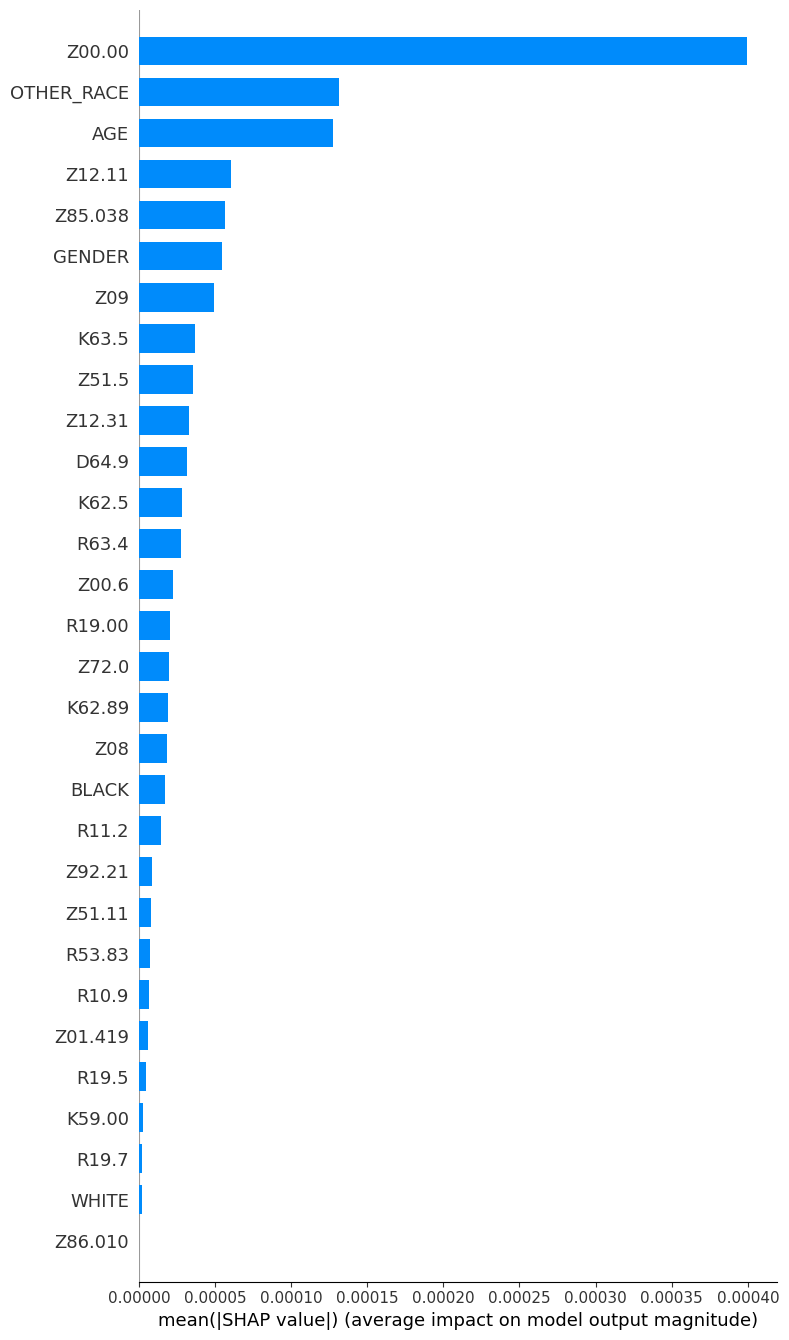

In [ ]:
#display which features contribute the most on average
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type='bar', max_display=30)

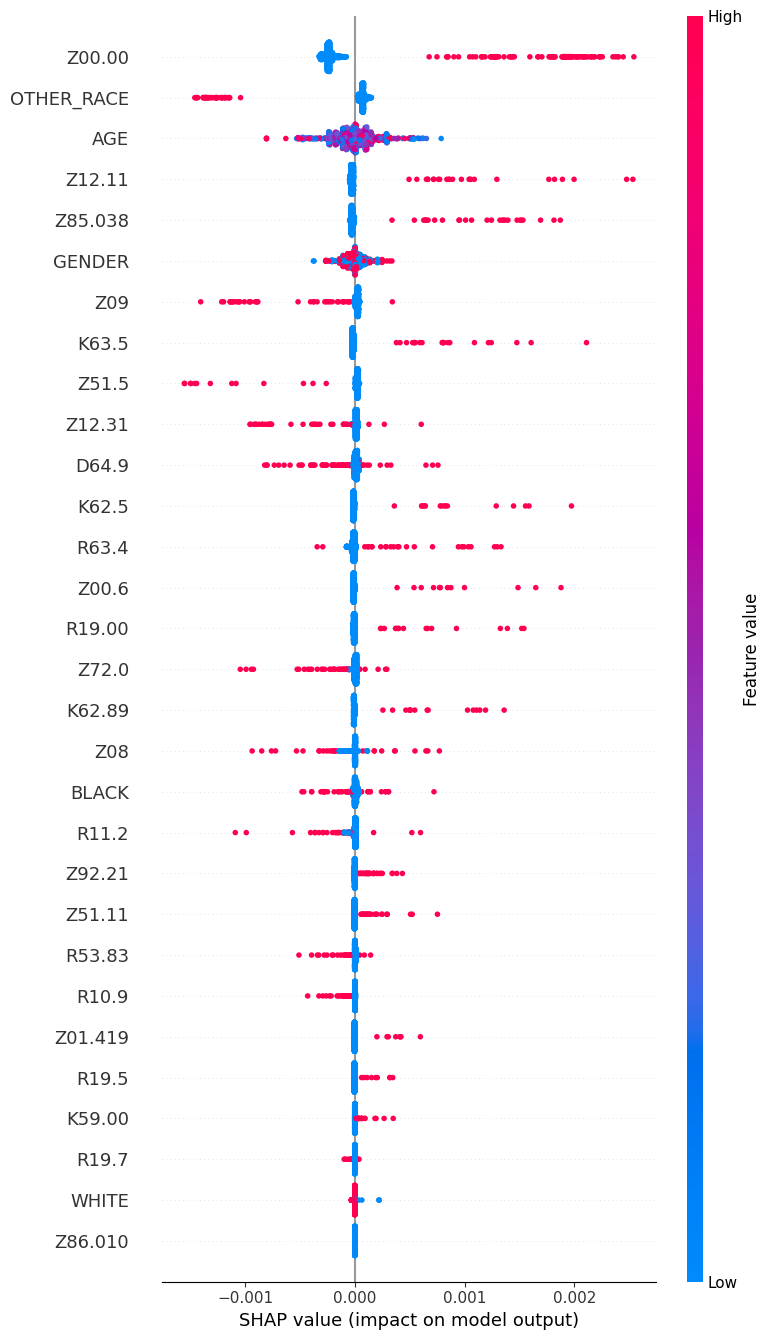

In [ ]:
#displays how each feature contributes to each individual prediction
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type='dot', max_display = 30)

In [ ]:
#all code after this point is not included in paper; involves the splitting of the data into two age groups and training, evaluating, and displaying results as above for each group
over45_model = XGBClassifier(n_estimators=10, learning_rate = .1, max_depth=25)
over45_model.fit(X_over45_train, y_over45_train)

print(">= 45 train and test accuracy: ")
print(get_accuracy(X_over45_train, y_over45_train, over45_model))
print(get_accuracy(X_over45_test, y_over45_test, over45_model))

under45_model = XGBClassifier(n_estimators=10, learning_rate = .1, max_depth=25)
under45_model.fit(X_under45_train, y_under45_train)

print("< 45 train and test accuracy: ")
print(get_accuracy(X_under45_train, y_under45_train, under45_model))
print(get_accuracy(X_under45_test, y_under45_test, under45_model))

>= 45 train and test accuracy: 
tensor(0.7044)
tensor(0.6223)
< 45 train and test accuracy: 
tensor(0.7255)
tensor(0.4872)


In [ ]:
m = XGBClassifier(n_estimators=10, learning_rate = .001, max_depth=5)
m.fit(X_over45_train, y_over45_train)

print(get_accuracy(X_over45_test, y_over45_test, m))

tensor(0.6277)


In [ ]:
over45_explainer = shap.TreeExplainer(over45_model)
shap_values_over45 = over45_explainer.shap_values(numpy.array(X_over45_train), check_additivity=False)

under45_explainer = shap.TreeExplainer(under45_model)
shap_values_under45 = under45_explainer.shap_values(numpy.array(X_under45_train), check_additivity=False)

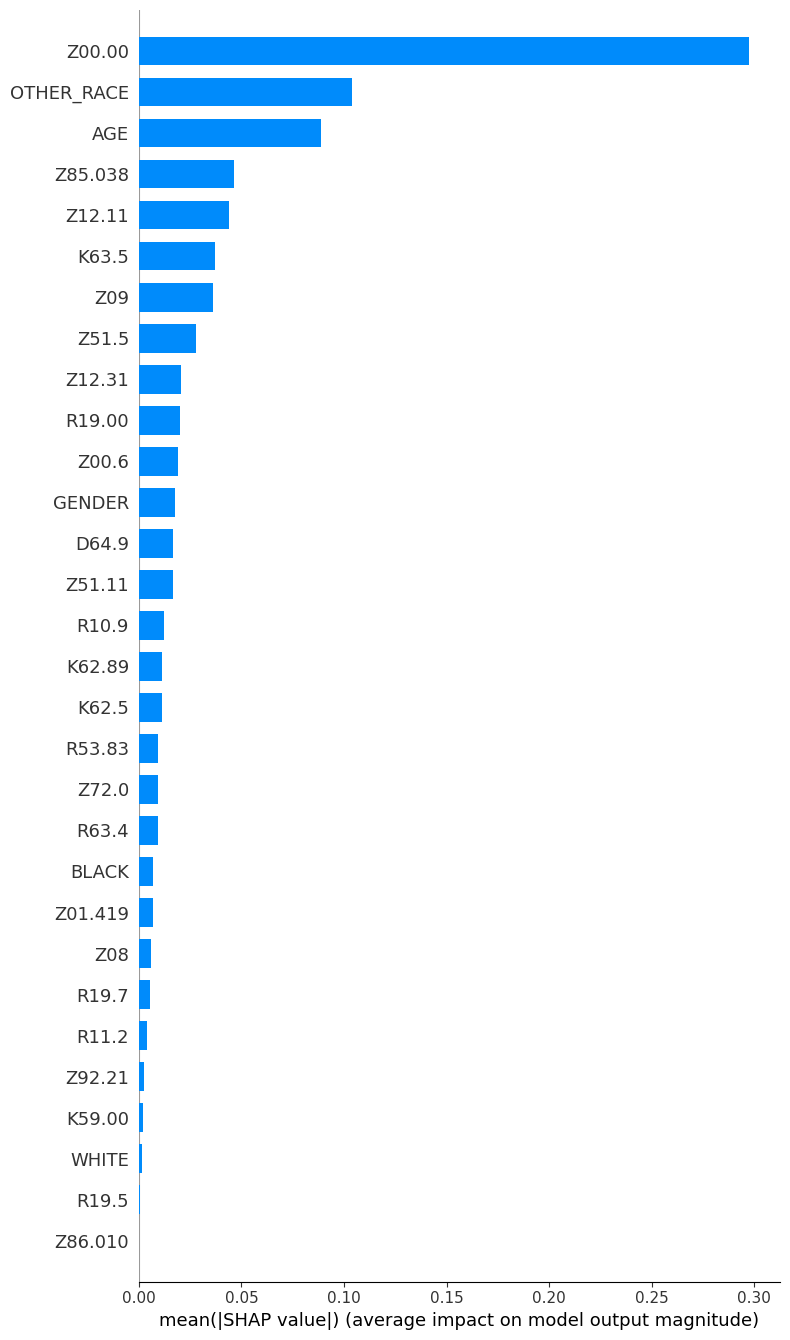

In [ ]:
shap.summary_plot(shap_values_over45, features=X_train, feature_names=X.columns, plot_type='bar', max_display=30)

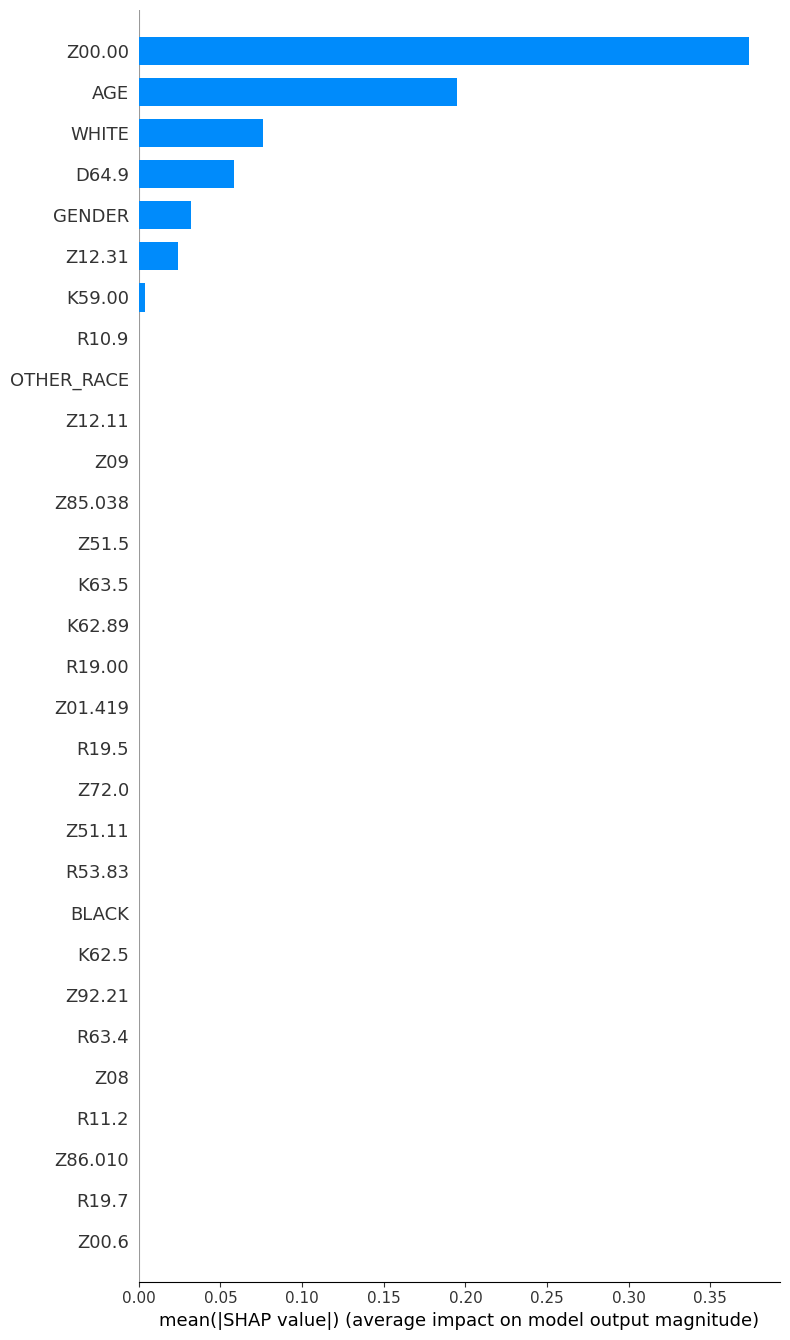

In [ ]:
shap.summary_plot(shap_values_under45, features=X_train, feature_names=X.columns, plot_type='bar', max_display=30)

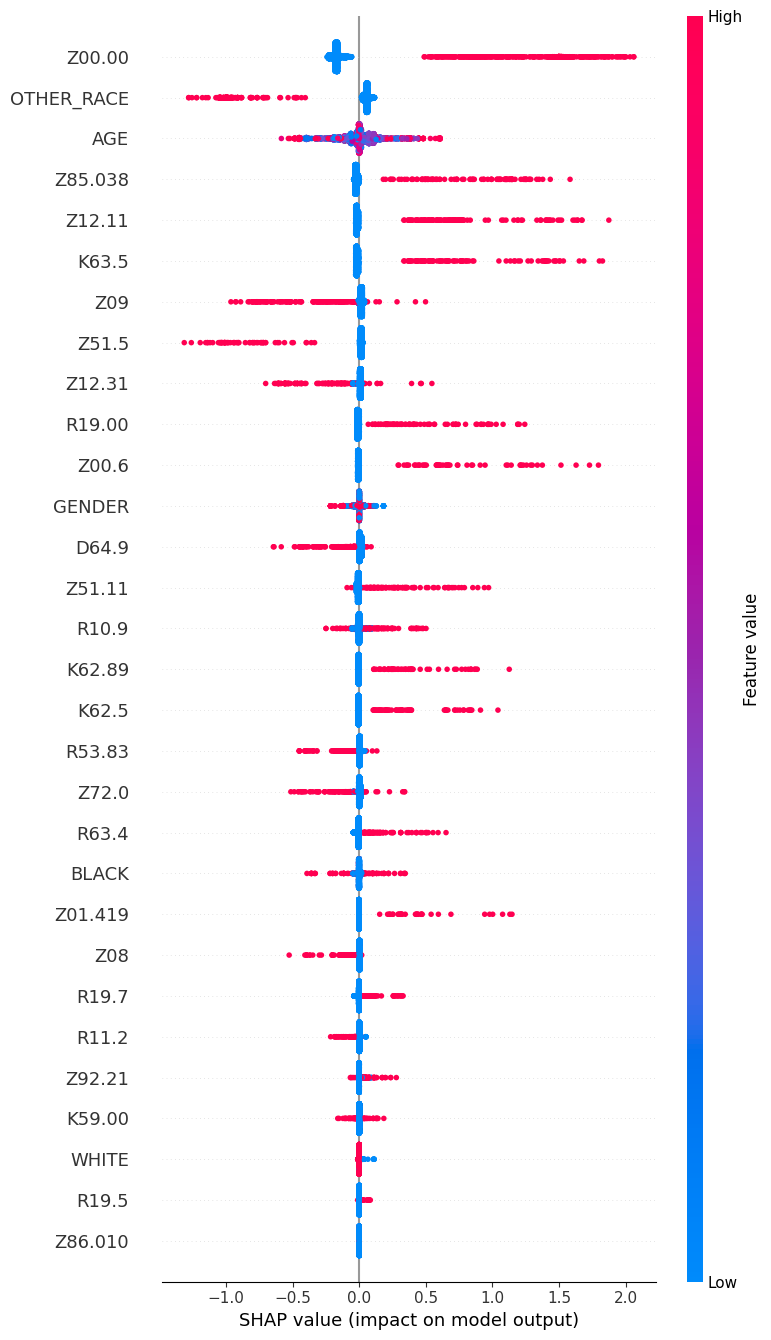

In [ ]:
shap.summary_plot(shap_values_over45, features=X_over45_train, feature_names=X.columns, plot_type='dot', max_display = 30)

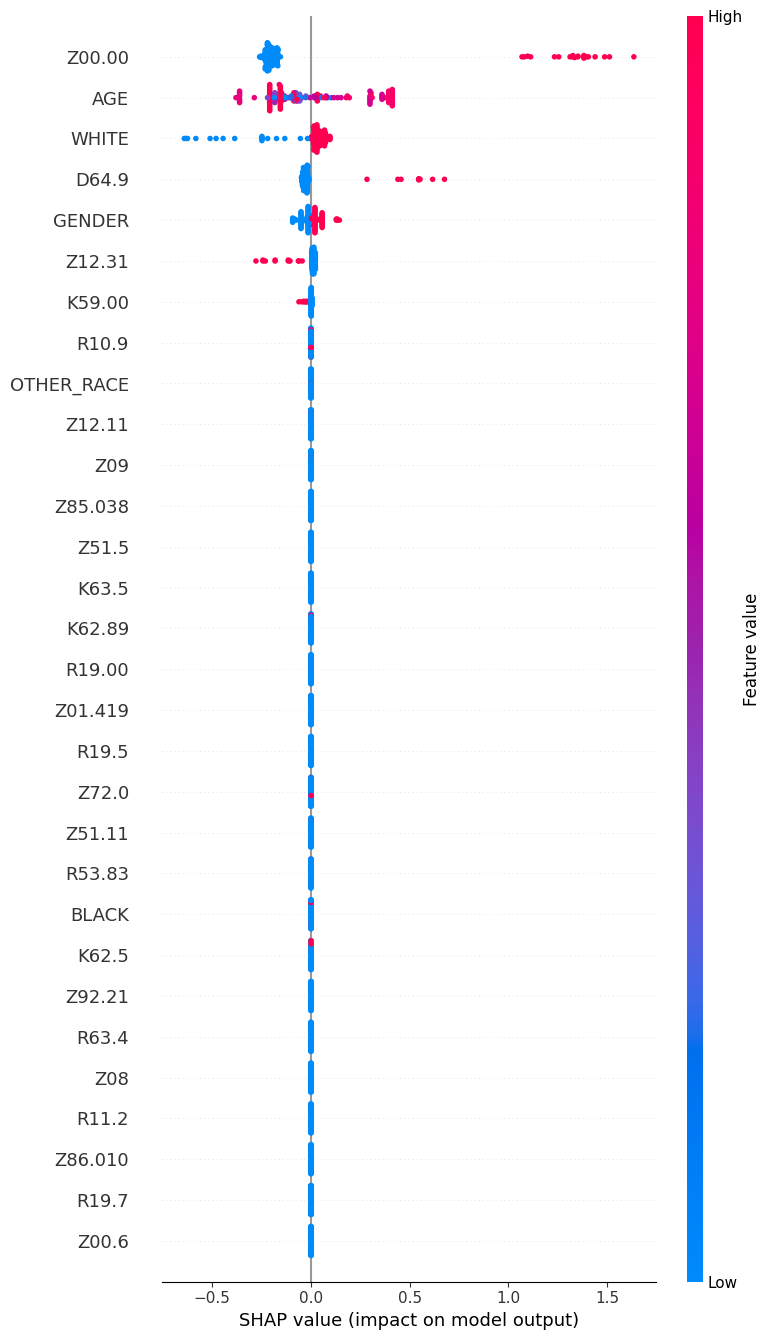

In [ ]:
shap.summary_plot(shap_values_under45, features=X_under45_train, feature_names=X.columns, plot_type='dot', max_display = 30)

In [ ]:
model = XGBClassifier(n_estimators=75, learning_rate = .1, max_depth=25)
model.fit(X_train, y_train)
print(model.predict_proba(X_train))


[[0.5712259  0.42877412]
 [0.49699628 0.5030037 ]
 [0.4955457  0.5044543 ]
 ...
 [0.6009031  0.3990969 ]
 [0.6063028  0.3936972 ]
 [0.9022983  0.09770171]]


## Neural Network

Unused in paper

In [ ]:
#construct pytorch NN
class CRC_NN(nn.Module):
  def __init__(self, num_neurons, num_layers, activation_function):
    super(CRC_NN, self).__init__()
    layers = []
    layers.append(nn.Linear(X_train.shape[1], num_neurons))
    layers.append(activation_function)
    for _ in range(num_layers - 1):
      layers.append(nn.Linear(num_neurons, num_neurons))
      layers.append(activation_function)
    layers.append(nn.Linear(num_neurons, 2))
    layers.append(activation_function)
    self.linear_relu_stack = nn.Sequential(*layers)
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
model = CRC_NN(32, 1, nn.Sigmoid()).to('cpu')

In [ ]:
learning_rate = 1e-2
batch_size = 64
epochs = 30

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(X_train, y_train, loss_fn, optimizer):
  size = X_train.shape[0]

  model.train()
  for batch, (X, y) in enumerate(zip(X_train, y_train)):
    # Compute prediction and loss
    pred = model(X)

    #pred = pred.squeeze()
    y = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=2).float()
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

def test_loop(X_test, y_test, loss_fn):
  size = X_test.shape[0]
  num_batches = size // batch_size
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in zip(X_test, y_test):
      pred = model(X)

      y = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=2).float()

      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(0) == y.argmax(0)).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(X_train, y_train, loss_fn, optimizer)
  test_loop(X_train, y_train, loss_fn)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 44.502685 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 51.2%, Avg loss: 44.461839 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 53.1%, Avg loss: 44.408143 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 54.9%, Avg loss: 44.333412 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 56.7%, Avg loss: 44.228686 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 58.2%, Avg loss: 44.085782 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 59.1%, Avg loss: 43.899647 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 59.8%, Avg loss: 43.669824 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 60.5%, Avg loss: 43.400320 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 60.8%, Avg loss: 43.098719 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 60.8

In [ ]:
test_loop(X_test, y_test, loss_fn)

Test Error: 
 Accuracy: 66.6%, Avg loss: 63.828448 



## PCA

Unused in paper

In [ ]:
x = StandardScaler().fit_transform(X)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
principalDf = pandas.DataFrame(data = principalComponents)

print(sum(pca.explained_variance_ratio_))
print(pca.components_)

0.2516375847151095
[[ 1.61854068e-03 -1.43591039e-03  7.26296270e-04 ...  3.64527780e-03
   2.60736479e-02  6.22463972e-03]
 [-3.09876981e-03 -1.85851064e-02  1.64169986e-02 ... -8.54221602e-03
   2.41792966e-03 -3.80608043e-03]
 [ 5.14770523e-03 -8.27571844e-03  5.41865993e-03 ... -2.49728958e-03
  -2.20442742e-02  3.66590132e-03]
 ...
 [-5.91058360e-03 -1.30088049e-02 -1.99488298e-02 ...  4.98258195e-03
   1.24560757e-02  4.28791236e-03]
 [ 3.54535986e-03  1.01335240e-02 -1.83613692e-02 ... -5.98905476e-05
  -2.73334551e-02 -1.95929016e-02]
 [ 2.33804910e-03 -3.76580213e-02 -2.17742678e-02 ...  1.97515003e-03
   3.39050642e-04  3.31251548e-02]]


# Misc

This section contains often repeated cells that may be useful for examining the structure of various data.

In [ ]:
case_df

,PID,CRC_DATE,AGE,GENDER,WHITE,BLACK,ASIAN,HISPANIC,OTHER_RACE,K00.1,...,D89.0,D89.1,D89.2,D89.810,D89.811,D89.812,D89.813,D89.832,D89.89,D89.9
0,3E93DB7BB5C649DAC38DEC2,1,0.518987,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,544E5386CD34D95A1FF2EE22,1,0.632911,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7123DDB2626EFDB5288A916,1,0.265823,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23F04E2B3DF1E0D5AFC687A8,1,0.531646,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5D9FEB2EDEB45B95E35BF63D,1,0.493671,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,6FF63186914BD56E9F03DA19,1,0.354430,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1654,589F0376B63867A9113104D1,1,0.481013,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1655,A69192B2BFD44A17AB78986C,1,0.632911,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1656,D386607BC86A3DC5561F1F98,1,0.443038,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
control_df

,PID,CRC_DATE,AGE,GENDER,WHITE,BLACK,ASIAN,HISPANIC,OTHER_RACE,K00.1,...,D89.0,D89.1,D89.2,D89.810,D89.811,D89.812,D89.813,D89.832,D89.89,D89.9
0,22406DF544A89BDCCECCD4B9,0,0.227848,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,217268BA60DEF129CE2F735,0,0.544304,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8D5B7496622DC43D0018B9FE,0,0.430380,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,410D9B1C395D0EE8AB11AE92,0,0.291139,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F855E8698DAD41648F9DA0ED,0,0.379747,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,EE14D16542687FA0CF7C25E6,0,0.544304,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1654,320B23A1F5E6833E1CFE9852,0,0.405063,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1655,5635EA546F7B4BDF3027BCD,0,0.455696,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1656,173B2BD916A6B8D7F53D41E5,0,0.607595,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(e[e['COHORT'] == 'CONTROL'].PATIENT_NUM.unique())

2654

In [ ]:
d.head()

,VISIT_NUM,PATIENT_NUM,ADMT_DT,DIAGNOSIS,DIAG_DESCRIPTION,DIAG_SEQUENCE_NUM
0,21FAAE61C8BB35FC8ABFCBA8,3E93DB7BB5C649DAC38DEC2,2020-04-14 11:00:00.000,C20,Stage IV carcinoma of rectum (CMS/HCC),2.0
1,214FD147D4E7CA28F740630A,466D985C6A0FACF70F6028AB,2018-12-04 09:30:00.000,M54.16,Subacute right lumbar radiculopathy,NaN
2,D32BBC67C6774B5B1666AC68,7C1AC8C2EE2AB2D0BF125932,2016-09-18 23:23:00.000,D63.1,Erythropoietin deficiency anemia,17.0
3,7ED13022F327F216E2A607EC,4A76C67CCCE17B3978C9A97E,2017-03-28 10:00:00.000,I10,White coat syndrome with hypertension,4.0
4,4F776E7EA7B396ED8D824900,91C06CB0F5E74CF2E879C2E0,2015-06-05 10:06:00.000,V45.79,ACQUIRED ABSENCE OF OTHER ORGAN,3.0


In [ ]:
d.ADMT_DT.unique().max()

'2023-12-19 00:00:00.000'